<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-libraries" data-toc-modified-id="Loading-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading libraries</a></span></li><li><span><a href="#Setting-seed-to-reproduce-the-results" data-toc-modified-id="Setting-seed-to-reproduce-the-results-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setting seed to reproduce the results</a></span></li><li><span><a href="#time-spend-in-block" data-toc-modified-id="time-spend-in-block-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>time spend in block</a></span></li><li><span><a href="#Creating-train-object" data-toc-modified-id="Creating-train-object-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating train object</a></span></li><li><span><a href="#creating-track-object" data-toc-modified-id="creating-track-object-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>creating track object</a></span></li><li><span><a href="#Creating-Simulation-object-including-trains-and-signals" data-toc-modified-id="Creating-Simulation-object-including-trains-and-signals-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Creating Simulation object including trains and signals</a></span></li><li><span><a href="#Optimisation-of-travel-time" data-toc-modified-id="Optimisation-of-travel-time-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Optimisation of travel time</a></span></li><li><span><a href="#creating-3D-visulatisation" data-toc-modified-id="creating-3D-visulatisation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>creating 3D visulatisation</a></span></li><li><span><a href="#greedy-hill-optimisation" data-toc-modified-id="greedy-hill-optimisation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>greedy hill optimisation</a></span></li><li><span><a href="#Random-Walk-optimisation" data-toc-modified-id="Random-Walk-optimisation-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Random Walk optimisation</a></span></li><li><span><a href="#Monte-carlo-optimisation" data-toc-modified-id="Monte-carlo-optimisation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Monte carlo optimisation</a></span></li><li><span><a href="#result-of-optimisation" data-toc-modified-id="result-of-optimisation-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>result of optimisation</a></span></li><li><span><a href="#Half-an-hour-delay-at-9-am" data-toc-modified-id="Half-an-hour-delay-at-9-am-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Half an hour delay at 9 am</a></span></li><li><span><a href="#Creating-network-class" data-toc-modified-id="Creating-network-class-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Creating network class</a></span></li><li><span><a href="#Delay-distribution" data-toc-modified-id="Delay-distribution-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Delay distribution</a></span></li></ul></div>

# Loading libraries 

In [1]:
import numpy as np
import math
import random
import simpy
import pandas as pd
import scipy.stats as stats
import string
import matplotlib as mpl
import matplotlib.pyplot as plt



In [29]:
import pandasql as ps
import plotly.graph_objects as go
import plotly

# Setting seed to reproduce the results


In [2]:
random.seed(1234)

Block function

In [32]:
def Block_Location(k):
    Bl_Loc = np.linspace(0, 145, k + 1)
    return (Bl_Loc)

Time spend at top speed

In [33]:
def TS_time(TS_Dist):  # The time spent at top speed
    Time = TS_Dist / 310
    return (Time)

In [34]:
def Dec_Time_Exit_Speed(Dec_Dist):  # The Exit Speed
    Out_Dict = {}
    Out_Dict['Exit_Speed'] = math.sqrt(max(310 ** 2 - 2 * 4878.0* Dec_Dist, 0))
    Out_Dict['Time'] = 2 * Dec_Dist / (310 + Out_Dict['Exit_Speed'])
    return (Out_Dict)

In [35]:
def Acc_Time(Entry_Speed):  # The Acc Time
    Output = {}
    Output['Time'] = ((310 / 3600 - Entry_Speed / 3600) / 0.72) / 3.6
    Output['Dist'] = ((Entry_Speed / 3600) * (Output['Time'] * 360) + 0.5 * 0.72 * (Output['Time'] * 360) ** 2) / 10
    return (Output)


# time spend in block

In [36]:
def Time_In_Block(i, Block_Loc, slow_down_ind, Entry_Speed):
    dist = Block_Loc[i] - Block_Loc[i - 1]
    #takes 15k for train to reach full speed and then decelerate
    Pre_Sig_Dist = 9.751
    TS_Dist = dist - Acc_Time(Entry_Speed)['Dist'] - slow_down_ind * Pre_Sig_Dist
    time = Acc_Time(Entry_Speed)['Time'] + TS_time(TS_Dist) + slow_down_ind * Dec_Time_Exit_Speed(Pre_Sig_Dist)['Time']

    #Provide for weather etc.
    time_random = np.random.normal(time,time/10)
    return (time_random)

In [43]:
class wait_time:
    def __init__(self):
        self.wt = 0

    def London_Euston(self):
        self.wt = 0
        return (self.wt)

    def London_OOC(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Int(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Curzon(self):
        self.wt = 0
        return (self.wt)

# Creating train object

In [37]:
class Train(object):
    def __init__(self, env, sig_blocks, res, wait_class):
        self.sig_blocks=sig_blocks
        self.res = res
        self.wait_class = wait_class
        self.env=env


    def Execute_Train(self ,ID):
        wc = self.wait_class
        row = {}
        row['No_Blocks'] = len(self.sig_blocks) - 1 # London and two birmingham blocks dont add to the total
        row['Train_No'] = ID

        yield (self.env.timeout(wc.London_Euston()))

        lon = self.res['London'].request()
        yield (lon)
        #print('Train {} leaves London Euston at {}'.format(ID, self.env.now))
        row['Departure_Time'] = self.env.now

        yield (self.env.timeout(5 / 60))  # 5 minute wait
        #print('Train {} arrives in London Old Oak Common at {}'.format(ID, self.env.now))
        yield (self.env.timeout(wc.London_OOC()))  # wait for mandatory two mins with an extra delay of an average of one minute
        #print('Train {} leaves London Old Oak Common at {}'.format(ID, self.env.now))

        req_list = []
        req_list.append(self.res['Straight'][0].request())
        yield (req_list[0])
        yield(self.res['London'].release(lon))
        # Enter the long straight between London and brimingham
        SD_Ind = False
        Entry_speed = 0
        for i in range(1, len(self.sig_blocks)):
            #print('Train {} enters signalling block {} at {}'.format(ID, i, self.env.now))
            if i == len(self.sig_blocks) - 1:
                SD_Ind = True
            elif self.res['Straight'][i].count > 0:
                SD_Ind = True
                Entry_speed = 0
            elif i != 1:
                SD_Ind = False
                Entry_speed = 300

            Tib = Time_In_Block(i, self.sig_blocks, SD_Ind, Entry_speed)
            yield (self.env.timeout(Tib))


            # When we arrive at birmingham
            if i == len(self.sig_blocks) - 1:
                #print('Train {} arrives in Birmingham Interchange at {}'.format(ID , self.env.now))
                yield (self.env.timeout(wc.Birmingham_Int()))  # wait for mandatory two mins with an extra delay of an average of one minute
                bir1 = self.res['Birmingham'][0].request()
                yield (bir1)

            else:
                #print('Train {} reaches end of signalling block {} at {}'.format(ID ,i , self.env.now))
                req_list.append(self.res['Straight'][i].request())
                yield (req_list[i])

            self.res['Straight'][i - 1].release(req_list[i - 1])

        #print('Train {} leaves Birmingham Interchange at {}'.format(ID, self.env.now))
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #print('Train {} is at Birmingham Signalling Block {}'.format(ID, self.env.now))
        bir2 = self.res['Birmingham'][1].request()
        yield (bir2)
        self.res['Birmingham'][0].release(bir1)
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        row['Arrival_Time'] = self.env.now
        self.res['Birmingham'][1].release(bir2)
        #print('Train {} arrives in Birmingham Curzon Street Common at {}'.format(ID, self.env.now))

        #append to output data frame
        global df_out
        df_out = df_out.append(row, ignore_index=True)

# creating track object

In [38]:
class London_2_Birmingham(object):
    def __init__(self, env, k, Times, Day_Num, wait_class):
        self.env = env
        self.k = k
        self.Times = Times
        self.Day_Num = Day_Num
        self.wait_class = wait_class
        self.df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': []})
        self.action = env.process(self.run(self.k, self.Times))


    # The overall process
    def run(self, k, Times):
        sig_blocks = Block_Location(k)

        # create resources
        avail = {}
        avail['Straight'] = self.Resources(k)  # A vector of train locations, True indcates presence of train
        avail['London'] = simpy.Resource(self.env, capacity=1)
        avail['Birmingham'] = self.Resources(2)

        global df_out
        df_out = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': []})

        Train_obj = Train(self.env, sig_blocks, avail, self.wait_class())

        x = 1  # Train ID
        self.env.process(Train_obj.Execute_Train(x))
        #self.df = self.df.append(row_vect, ignore_index=True)

        while True:
            yield (self.env.timeout(1 / Times))  # Times per hour
            x = x + 1
            self.env.process(Train_obj.Execute_Train(x))
            #self.df = self.df.append(row_vect, ignore_index=True)

    def Resources(self, k):
        out_l = []
        for i in range(k):
            out_l.append(simpy.Resource(self.env, capacity=1))
        return (out_l)

    def Return_Df(self):
        self.df = df_out
        self.df['Journey_Time'] = self.df['Arrival_Time'] - self.df['Departure_Time']
        self.df['Day'] = self.Day_Num
        self.df['Trains_PH'] = self.Times
        return (self.df)

In [11]:


def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now(env):
    return daytime(env.now)

# Creating Simulation object including trains and signals

Max a = 0.76 m/s2 giving time to accelerate maximum velocity of 86.1 m/s as time = v-u/a = 86.1/0.76 = 113.3 s and distance travelled till max speed is reached is given by s = u t + 0.5 a t2 since u or initial velocity is 0 equation becomes s = 0.5*a*t**2 = 0.5*0.76*113.3**2 = 4878 m
•	Energy efficient deceleration time and distance covered
Energy optimal deceleration time = 86.1/0.38 = 226.6 s and distance =86.1*226.6 – 0.5*0.38*226.6**2 = 9751 m
•	Emergency deceleration time and distance covered
Emergency deceleration time = 86.1/2.5 = 34.44 s and distance = 86.1*34.44 – 0.5*2.5*34.44**2 = 1483 m
The above scenario indicates that we will have to design blocks atleast 9751*1.5 = 14626 m for safer and energy efficient stop between trains.
The total distance is 145 km and needs equal distance between blocks limiting the choice for k= {1,2, 4, 5, 8, 10, 20, 25, 29, 40, 50…}. But minimum distance between 2 blocks are said to be 14000 m stating maximum block as {1,2,4,5,8,10}
This limits the simulation as range of K is between 1 to 10. 


Assuming maximum number of signal block installed in line that is 10
The distance between each block comes to around 14500 meters so for a train to safely travel we need the first train to cross this block hence we can say that by the time the first train has crossed the first signal we cannot send the second train. 
Calculating the time required for the first train to cross the first block
s= u*t + 0.5*a*t**2 since initial velocity is zero the equation becomes
s=0.5*a*t**2 
14500=0.5*0.76*t**2
resolving the equation for t we get time taken for first train to cross the first block is 195 seconds and the delay in signal to turn green is 5 seconds making the total time to 200 seconds
this indicates that the second train can only leave after 200 seconds which is nearly 3 mins making maximum number of train possible in 1 hour as 60/3 = 20 trains

In [40]:
Trains_PH = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]
Sig_blocks = range(1, 11)

Creating simulation function with number of days to run the simulation

In [44]:
def Full_Simulation(n_days):  # few Variable Inputs, keep everything consistent

    Output_df = pd.DataFrame(
        {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
         'Trains_PH': []})

    for Tr in Trains_PH:
        for sig in Sig_blocks:
            for day in range(1, n_days+1): 
                env = simpy.Environment()
                proc = London_2_Birmingham(env, sig, Tr, day, wait_time)
                env.run(until=18)  # Assume trains operate 6am to midnight 18 hours
                Output_df = Output_df.append(proc.Return_Df(), ignore_index=True)
    return (Output_df)


In [45]:
Sim_Data = Full_Simulation(1)

In [46]:
Sim_Data

,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH
0,1.0,1.0,0.000000,0.908358,0.908358,1.0,1.0
1,1.0,2.0,1.000000,1.906804,0.906804,1.0,1.0
2,1.0,3.0,2.000000,2.904839,0.904839,1.0,1.0
3,1.0,4.0,3.000000,3.823314,0.823314,1.0,1.0
4,1.0,5.0,4.000000,4.805883,0.805883,1.0,1.0
...,...,...,...,...,...,...,...
7675,10.0,117.0,15.674439,17.397565,1.723125,1.0,20.0
7676,10.0,118.0,15.791640,17.564624,1.772984,1.0,20.0
7677,10.0,119.0,15.989598,17.701446,1.711848,1.0,20.0
7678,10.0,120.0,16.120304,17.849603,1.729299,1.0,20.0


Confirming no collisions of train has occured

In [47]:
ps.sqldf('''
        select count(*) as num
        from Sim_Data as bse
        left join Sim_Data as alt 
            on bse.No_Blocks = alt.No_Blocks
            and bse.Day = alt.Day
            and bse.Trains_PH = alt.Trains_PH
            and alt.Train_No > bse.Train_No
        where alt.Arrival_Time < bse.Arrival_Time
        ''')

,num
0,0


# Optimisation of travel time

In [48]:
Sim_Data['Journey_Time1'] = Sim_Data['Journey_Time'] + 1/Sim_Data['Trains_PH']
Journey_Time = Sim_Data.groupby(['Trains_PH', 'No_Blocks']).agg(
        AVG_Journey_Time=pd.NamedAgg(column = 'Journey_Time1', aggfunc='mean'),
        STD_Journey_Time=pd.NamedAgg(column = 'Journey_Time1', aggfunc='std'))
Journey_Time = Journey_Time.reset_index(level=['Trains_PH', 'No_Blocks'])

# creating 3D visulatisation

In [49]:
def plot_3D(df,var):
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    X = np.unique(df['Trains_PH'].values)
    Y = np.unique(df['No_Blocks'].values)
    Z = df_melt.values

    df_fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y
                                         , contours=dict(x=dict(show=True, start=1, end=20, size=1, color='white')
                                                         , y=dict(show=True, start=1, end=10, size=1, color='white'))
                                         # line = dict(smoothing=0))
                                         )])
    df_fig.update_layout(scene=dict(
        xaxis_title='Trains Per hour',
        yaxis_title='Number of Signalling Blocks',
        zaxis_title=var),
    )

    plotly.offline.plot(df_fig, filename='file.html')

In [50]:
plot_3D(Journey_Time, 'AVG_Journey_Time')
plot_3D(Journey_Time, 'STD_Journey_Time')

# function for optimisation

In [51]:
def Return_JT(n_Trains_PH, n_Sig_blocks):
    return (float(Journey_Time['AVG_Journey_Time'][Journey_Time['Trains_PH'] == n_Trains_PH][
                      Journey_Time['No_Blocks'] == n_Sig_blocks]))

def Return_JT_STD(n_Trains_PH, n_Sig_blocks):
    return (float(Journey_Time['STD_Journey_Time'][Journey_Time['Trains_PH'] == n_Trains_PH][
                      Journey_Time['No_Blocks'] == n_Sig_blocks]))

# greedy hill optimisation

 x y  f(x, y)
 7 1    1.236
 8 1    1.197
 9 1    1.193
10 2    1.160
 x y  f(x, y)
 0 1    1.860
 1 2    1.342
 2 3    1.205
 2 4    1.183
 3 5    1.144
 3 6    1.106
 3 7    1.104
 4 8    1.096
 4 9    1.095


(9, 5, 15, 1.0948549940091983)

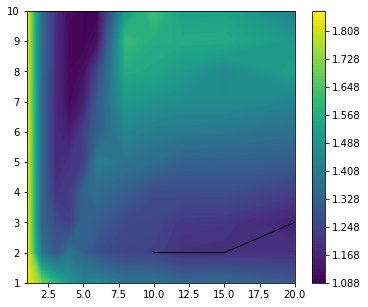

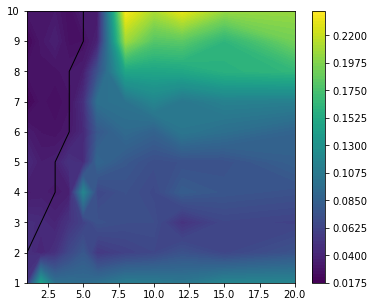

In [52]:
def neighbours(x, y, xmin, xmax, ymin, ymax):
    return [(x + 1, y - 1) if x < xmax and 0 < y else None,
            (x + 1, y) if x < xmax else None,
            (x + 1, y + 1) if x < xmax and y < ymax else None,
            (x, y + 1) if y < ymax else None,
            (x - 1, y + 1) if 0 < x and y < ymax else None,
            (x - 1, y) if 0 < x else None,
            (x - 1, y - 1) if 0 < x and 0 < y else None,
            (x, y - 1) if 0 < y else None]


def Greedy_Hill_Climbing(f , df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    fmin = f(Trains_PH_sort[x0], Sig_blocks_sort[y0])

    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in neighbours(xi, yi, xmin, xmax, ymin, ymax):
            if xy != None:
                x, y = xy
                ff = Return_JT(Trains_PH_sort[x], Sig_blocks_sort[y])
                if ff < fi:
                    xi = x
                    yi = y
                    fi = ff
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='black', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Greedy_Hill_Climbing(Return_JT, Journey_Time, 'AVG_Journey_Time')
Greedy_Hill_Climbing(Return_JT, Journey_Time, 'STD_Journey_Time')


# Random Walk optimisation

 x y  f(x, y)
 9 0    1.349
10 1    1.199
 9 1    1.193
10 2    1.160
 x y  f(x, y)
10 1    1.199
10 2    1.160


(2, 20, 3, 1.1598331437437275)

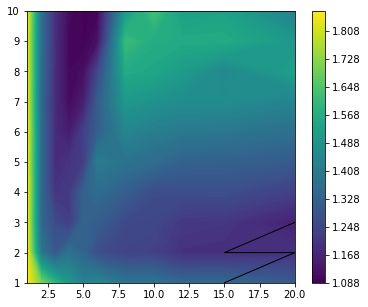

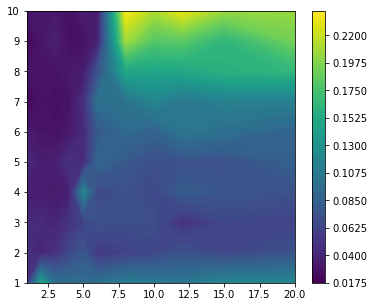

In [53]:
def neighbours_Random(x, y, xmin, xmax, ymin, ymax):
    return ([(x + 1, y - 1)] if x < xmax and 0 < y else []
            ) + ([(x + 1, y)] if x < xmax else []
                 ) + ([(x + 1, y + 1)] if (x < xmax and y < ymax) else []
                      ) + ([(x, y + 1)] if (y < ymax) else []
                           ) + ([(x - 1, y + 1)] if (0 < x and y < ymax) else []
                                ) + ([(x - 1, y)] if (0 < x) else []
                                     ) + ([(x - 1, y - 1)] if (0 < x and 0 < y) else []
                                          ) + ([(x, y - 1)] if (0 < y) else [])


def Randomized_Hill_Climbing(f , df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x0 = random.choice(Trains_PH_idx)
    y0 = random.choice(Sig_blocks_idx)
    xp = [x0]
    yp = [y0]
    fmin = f(Trains_PH_sort[x0], Sig_blocks_sort[y0])

    xmin = 0
    ymin = 0
    xmax = len(Trains_PH_sort) - 1
    ymax = len(Sig_blocks_sort) - 1

    print(f"{' x'}{' y'}{'f(x, y)':>9s}")
    print(f"{x0:2d}{y0:2d}{fmin:9.3f}")

    while True:
        xi = xp[-1]
        yi = yp[-1]
        fi = fmin
        for xy in np.random.permutation(neighbours_Random(xi, yi, xmin, xmax, ymin, ymax)):
            x, y = xy
            ff = f(Trains_PH_sort[x], Sig_blocks_sort[y])
            if ff < fi:
                xi = x
                yi = y
                fi = ff
                break
        if fi == fmin:
            break

        xp += [xi]
        yp += [yi]
        fmin = fi
        print(f"{xi:2d}{yi:2d}{fi:9.3f}")
          
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.plot([Trains_PH_sort[x] for x in xp], [Sig_blocks_sort[y] for y in yp], c='black', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Randomized_Hill_Climbing(Return_JT , Journey_Time, 'AVG_Journey_Time')
Randomized_Hill_Climbing(Return_JT , Journey_Time, 'STD_Journey_Time')


# Monte carlo optimisation

(4, 6, 15, 1.097190355927192)

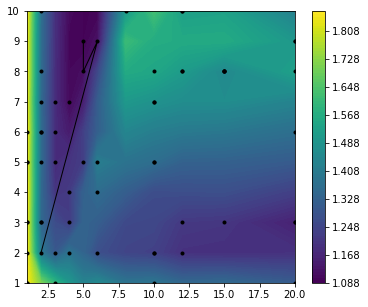

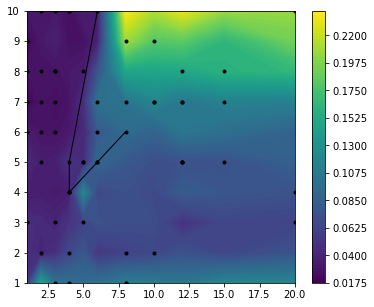

In [54]:
def Monte_Carlo(n, f, df, var):
    Trains_PH_sort = sorted(Trains_PH)
    Sig_blocks_sort = sorted(Sig_blocks)

    Trains_PH_idx = range(len(Trains_PH_sort))
    Sig_blocks_idx = range(len(Sig_blocks_sort))

    x = [random.choice(Trains_PH_idx) for i in range(n)]
    y = [random.choice(Sig_blocks_idx) for i in range(n)]
    xp = [x[0]]
    yp = [y[0]]
    fmin = f(Trains_PH_sort[xp[0]], Sig_blocks_sort[yp[0]])

    for i in range(1, len(x)):
        fi = f(Trains_PH_sort[x[i]], Sig_blocks_sort[y[i]])
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
            
    df_melt = df[['Trains_PH','No_Blocks',var]].pivot(columns='Trains_PH', index='No_Blocks')

    fig, ax = plt.subplots(1, 1)
    fig.set_figwidth(6)
    fig.set_figheight(5)
    cs = ax.contourf(Trains_PH_sort, Sig_blocks_sort, df_melt.values, 100)
    fig.colorbar(cs, ax=ax)

    plt.scatter([Trains_PH_sort[i] for i in x], [Sig_blocks_sort[i] for i in y], c='black', marker='.')

    plt.plot([Trains_PH_sort[i] for i in xp], [Sig_blocks_sort[i] for i in yp], c='black', lw=1)
    return len(xp), Trains_PH_sort[xp[-1]], Trains_PH_sort[yp[-1]], f(Trains_PH_sort[xp[-1]],
                                                                              Sig_blocks_sort[yp[-1]])


Monte_Carlo(60, Return_JT, Journey_Time, 'AVG_Journey_Time')
Monte_Carlo(60, Return_JT, Journey_Time, 'STD_Journey_Time')

# result of optimisation
Clearly the optimal solution to minimize journey time is to realease 5 trains per hour and use 10 signalling blocks. This is intuitive as the wait time for passengers is reasonable given the frequency of trains. The low frequency of trains means that disruption is infrequent along the stretch between London and Birmingham.

Although this optimizes the journey time, it is below the economic requirement of 9 trains per hour. Assuming this as a constraint, the best option would be to use 20 Trains per hour and use two signalling blocks. The large frequency of trains means that wait times are very low and the small number of signalling blocks means that trains spend a lot of time at top speed.

# Half an hour delay at 9 am 

In [55]:
no_of_blocks = 14
block_lenght = 10.36
avg_wait_time = 300
mean = 3.378
sigma = 0.751

In [56]:
acc_time = 113.3
maxV = 86.1
dist_covered = 4878
time_per_unit_distance = 0.023

In [57]:
def blocks(N):
    b1 = 1
    b3= 2
    b2=N-b1-b3
    return b1,b2,b3

In [58]:
def data(N):
    data = pd.DataFrame()
    for i in range(N): 
                data.at[i, 'From'] = 'S' + str(i+1)
                data.at[i, 'To'] = 'S' + str(i+2)
                data.at[i,'Direction'] = "LOOC_BI"
    
    return data         
        

In [59]:
def structure_data(k):
    
    a,b,c = blocks(k)
    y = a+b+c+3
    
    dt = data(y)
            
    
    #Distance is splitted according to the number of blocks
    total_distance = 145000
    distance_split = total_distance / y
    
    dt['Distance'] = distance_split
    dt['Line'] = "HS2"
    dt['Running Time'] = ''
    dt['Dwell Time'] = np.random.lognormal(mean,sigma, size=y)
    
    
    dt['Max Acc.'] = 0.76
    dt['Max Vel.'] = 86.1
    
      
    return dt



In [60]:
random.seed(123)
dt = structure_data(10)
dt['Distance']=dt['Distance'].apply(lambda x: int(x))
dt['Dwell Time']=dt['Dwell Time'].apply(lambda x: int(x))
dt['From'] = dt['From'].replace(['S1'],'London Old Oak Common')
dt['To'] = dt['To'].replace(['S14'],'Birmingham Interchange')




In [61]:
def timeTo(a, maxV, d):
    # a       constant acceleration, m/s²
    # maxV    maximumum velocity, m/s
    # d       distance, km
    # return  time in seconds required to travel
    # 
    ta = maxV/a                       
    da = a*ta**2        # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < da):        # train never reaches full speed?
        return np.sqrt(4.0*d/(a))     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return (2*ta) + (d-da)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

In [62]:
dt['Drive Time'] = None
for i in range(len(dt)):
    dist = dt.at[i, 'Distance']
    a = dt.at[i, 'Max Acc.']
    v = dt.at[i, 'Max Vel.']
    dt.at[i, 'Drive Time']=int(timeTo(a, v, dist))

In [63]:
dt['Running Time'] = dt['Dwell Time'] + dt['Drive Time']

In [64]:
dt

,From,To,Direction,Distance,Line,Running Time,Dwell Time,Max Acc.,Max Vel.,Drive Time
0,London Old Oak Common,S2,LOOC_BI,11153,HS2,355,113,0.76,86.1,242
1,S2,S3,LOOC_BI,11153,HS2,257,15,0.76,86.1,242
2,S3,S4,LOOC_BI,11153,HS2,298,56,0.76,86.1,242
3,S4,S5,LOOC_BI,11153,HS2,262,20,0.76,86.1,242
4,S5,S6,LOOC_BI,11153,HS2,332,90,0.76,86.1,242
5,S6,S7,LOOC_BI,11153,HS2,275,33,0.76,86.1,242
6,S7,S8,LOOC_BI,11153,HS2,258,16,0.76,86.1,242
7,S8,S9,LOOC_BI,11153,HS2,391,149,0.76,86.1,242
8,S9,S10,LOOC_BI,11153,HS2,276,34,0.76,86.1,242
9,S10,S11,LOOC_BI,11153,HS2,311,69,0.76,86.1,242


Creating plot function

In [168]:
def plot(data, xmin, xmax, pdf=None, bins=None, 
         μ=None, σ=None,
         
         title=None, xlabel=None, ylabel=None):
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax = fig.gca()
    
    μ = np.mean(data)
    σ = np.std(data)  
    minx = min(data)
    maxx = max(data)
        
    ax.set_xlim(xmin, xmax)
    
    if title!=None:
        plt.title(title)
        
    plt.hist(data, bins=bins, density=True)
    
    # calculate parameter for text positioning
    dx=(xmax-xmin)*0.02
    ymin, ymax=plt.ylim()
    ypos=ymin+0.9*(ymax-ymin)
     
    # plot the probability density function if one is given
    if pdf!=None:
        X = list(np.linspace(xmin, xmax, 100))
        Y = [ pdf(x) for x in X]
        plt.plot(X, Y, lw=2, color='red')
 
    ax.axvline(x=μ, color='red', linestyle='dashed', lw=2)
    plt.text(μ+dx, ypos, f"μ={μ:3.2f}", color='red', fontsize=14)
    
    ax.axvline(x=minx, color='red', linestyle=':')
    ax.axvline(x=maxx, color='red', linestyle=':')

        
    plt.grid(True)

# Creating network class

In [129]:
class NetworkNode:
    
    def __init__(self, location, line):
        self.location=location
        self.line=line
        self.tracing=False
        self.incidents=[]

    # is only used in connection with tracing
    def setTrack(self, track):
        self.track=track
        
    def isTracing(self):
        return self.tracing and self.track.isTracing()
    
    def trace(self):
        self.tracing=True
        
    def trace_prefix(self, train):
        global max_line_name_length
        global max_direction_length
        return f"{now():s} " \
               f"{self.line:{max_line_name_length}s} " \
               f"[Train {train.getNo():2d} " \
               f"{train.getDirection():{max_direction_length}s}]"
    
    def arr(self, train):
        if self.isTracing() and train.isTracing():
            print(f"{self.trace_prefix(train):s} arr {self.loc():s}")        

    def dep(self, train, dest):
        if self.isTracing() and train.isTracing():
            print(f"{self.trace_prefix(train):s} dep {self.loc():s} for {dest.loc():s}")
        
    def loc(self):
        return self.location
    
    def __str__(self):
        return self.location
    

    def getResource(self):
        pass
    
    # NEW: Incident Handling
    # trace output for incident
    def inc(self, train):
        if self.isTracing() or train.isTracing():
            delay=self.incidentDelay()
            message=f"expected delay {daytime(delay):s}" if delay>0 else "incident cleared"
            print(f"{self.trace_prefix(train):s} inc {self.loc():s} {message:s}")        
            
    # registers an incident
    def registerIncident(self, incident):
        self.incidents+=[incident]
        
    # checks if there is currently an incident in progress
    # if yes, it returns True otherwise False
    def isIncident(self):
        for inc in self.incidents:
            if inc.active():
                return True
        return False
        
    # if there is currently an incident in progress it returns
    # the time the incident will probably continue, otherwise it returns 0
    def incidentDelay(self):
        stopTime=0
        for incident in self.incidents:
            if incident.active():
                stopTime=max(stopTime, incident.stopTime())
        return 0 if stopTime==0 else stopTime-env.now

In [130]:
class Depot(NetworkNode):
    def __init__(self, location, line, direction):
        super().__init__(location+" (DEPOT)", line)
        self.direction=direction
        
    def driveTime(self):
        return 20
    
    def dwellTime(self):
        return 10
    
    def dep(self, train, dest):
        train.setDirection(self.direction)
        super().dep(train, dest)
        
    def getResource(self):
        return None

In [131]:
class Station(NetworkNode):
    def __init__(self, location, line, direction):
        super().__init__(location, line)
        self.location=location
        self.line=line
        self.direction=direction
        self.resource=simpy.Resource(env, capacity=1)
        
        dd=dt[dt['Line']==self.line]
        dd=dd[dd['Direction']==self.direction]
        dd=dd[dd['From']==location]
        
        if len(dd)==0:
            # last node in a direction, the last passengers leave the train
            # and the train moves into the Cross-Over or the Depot
            self.drive_time=20
            self.dwell_time=60
        else:
            self.drive_time=dd.iloc[0].at['Drive Time']
            self.dwell_time=dd.iloc[0].at['Dwell Time']
            

    def driveTime(self):
        return self.drive_time
    
    def dwellTime(self):
        return self.dwell_time 
    
    def __str__(self):
        return self.location + " (" + self.direction[0] + ")"

    def getResource(self):
        return self.resource

In [132]:
class CrossOver(NetworkNode):
    def __init__(self, location, line, direction, capacity=2):
        super().__init__(location+" (X)", line)
        self.direction=direction
        self.resource=simpy.Resource(env, capacity=2)
        
    def driveTime(self):
        return 20
    
    def dwellTime(self):
        return 300
    
    def dep(self, train, dest):
        train.setDirection(self.direction)
        super().dep(train, dest)
        
    def getResource(self):
        return self.resource

In [133]:
class Track(object):
    def __init__(self, network, line, direction, depot, stations):
        self.network=network
        self.line=line
        self.direction=direction
        
        self.track=[depot]+stations+[depot]
        for s in self.track:
            s.setTrack(self)
            
        self.tracing=False
        self.tracingTrains=False
        self.tracingTrainNos=[]
    
    def isTracing(self):
        return self.tracing and self.network.isTracing()

    def isTracingTrains(self):
        return self.tracingTrains and self.network.isTracing()
    
    def trace(self, loc=None, train=None):
        self.tracing=True
        if loc is None:
            for s in self.track:
                s.trace()
            if train is not None:
                self.tracingTrains=True
                self.tracingTrainNos.append(train)
        else:
            for s in self.track:
                if s.loc()==loc:
                    s.trace()
            if train is not None:
                self.tracingTrains=True
                self.tracingTrainNos.append(train)

    def getNetwork(self):
        return self.network
    
    def getLine(self):
        return self.line
    
    def getStations(self):
        return self.track
    
    def setTiming(self, start, stop, timing):
        self.start=start*3600
        self.stop=stop*3600
        self.timing=timing
        
    def process(self):
        yield env.timeout(self.start-env.now) # the line starts operating at 6am
        for i in range(int((self.stop-self.start)/self.timing)):
            t=Train(i, self)
            if self.tracingTrains and i in self.tracingTrainNos:
                t.trace()
            env.process(t.process())
            yield env.timeout(self.timing)     
            
    def __str__(self):
        direction = "" if self.direction is None else " ("+self.direction+")"
        stations = " - ".join([ str(s) for s in self.track ])
        return self.line + direction + ": " + stations

In [134]:
def allStations(line, direction):
    dl=dt[dt['Line']==line]
    ds=dl[dl['Direction']==direction]
    stations=ds['From'].to_list()
    stations+=[ds['To'].to_list()[-1]]
    return [ Station(s, line, direction) for s in stations ]

In [135]:
def allTracks(network):
    lines=[]
    for line in dt['Line'].unique():
        directions=dt[dt['Line']==line]['Direction'].unique()
        stations=[ allStations(line, d) for d in directions]
    
        depot = Depot(stations[0][0].loc(), line, directions[0])
        #x = CrossOver(stations[0][-1].loc(), line, directions[1])
        l = Track(network, line, None, depot, stations[0])
        lines += [l]

    return lines

In [136]:
class Network(object):
    def __init__(self, start, stop, timing):
        self.tracks=allTracks(self)
        self.start=start
        self.stop=stop
        self.timing=timing
        
        self.tracing=False
        self.tracingStart=None
        self.tracingStop=None
        
    def isTracing(self):
        return self.tracing and \
                (self.tracingStart is None or self.tracingStart<=env.now) and \
                (self.tracingStop is None or env.now <= self.tracingStop)
    
    def trace(self, line=None, loc=None, train=None, start=None, stop=None):
        self.tracing = True
        self.tracingStart = parseTime(start)
        self.tracingStop = parseTime(stop)
        if line is None:
            for t in self.tracks:
                t.trace(loc=loc, train=train)
        else:
            for t in self.tracks:
                if t.getLine()==line:
                    t.trace(loc=loc, train=train)
    
    def registerIncident(self, start, stop, line=None, direction=None, loc=None):
        incident = Incident(start, stop)
        for t in self.tracks:
            if line is None or t.getLine()==line:
                for s in t.getStations():
                    if direction is None or s.getDirection()==direction:
                        if loc is None or s.loc()==loc:
                            s.registerIncident(incident)
    
    def process(self):
        for t in self.tracks:
            t.setTiming(self.start, self.stop, self.timing)
            yield env.timeout(self.start-env.now) # the line starts operating at 6am
            env.process(t.process())
            

In [137]:
class Train(object):  
    def __init__(self, i, track):
        self.no=i
        self.track = track

        self.direction = None
        self.tracing = False

    def setDirection(self, direction):
        self.direction=direction

    def getDirection(self):
        return self.direction
    
    def getNo(self):
        return self.no
    
    def isTracing(self):
        return self.track.isTracing() and \
                (not self.track.isTracingTrains() or self.tracing)
    
    def trace(self):
        self.tracing=True
            
    def traceOff(self):
        self.tracing=False
        
    def process(self):

        stations = self.track.getStations()
        
        here = stations[0]
        here_req = None
        
        for dest in stations[1:]:
            
  
            drivetime=here.driveTime()
            dwelltime=here.dwellTime()
            
            yield env.timeout(dwelltime)

            if here.isIncident():
                here.inc(self)
                yield env.timeout(here.incidentDelay())
                here.inc(self)
                
            if dest.getResource() is not None:
                dest_req = dest.getResource().request()
                yield dest_req
            else:
                dest_req = None
            
            # if the train doesn't get immediate access, it continues waiting 
            # in the current station ('here').
            # if the train got access the train departs from 'here'for 'dest'
            
            here.dep(self, dest)
            
            # Once the train has completely left the station, the train
            # will release the track of station ('here'). 
            # We assume that the train has left the station after 10 secs  
            delaytime=min(drivetime, 10)
            yield env.timeout(delaytime)
            if here_req is not None:
                here.getResource().release(here_req)

            # the train proceeds to drive to the next station ('dest')
            yield env.timeout(drivetime-delaytime)
            
            dest.arr(self)
            here = dest
            here_req=dest_req



In [138]:
class Incident:
    
    def __init__(self, start, stop):
        self.start = parseTime(start)
        self.stop = parseTime(stop)
        
    def active(self):
        return self.start <= env.now and env.now <= self.stop
    
    def startTime(self):
        return self.start
    
    def stopTime(self):
        return self.stop

In [139]:
max_line_name_length = max([len(line) for line in dt['Line'].unique()])
max_direction_length = max([len(line) for line in dt['Direction'].unique()])

In [140]:
def isPeakTime():
    now=env.now
    return (3600*7<=now and now<=3600*10) or \
           (3600*16<=now and now<=3600*19)

In [141]:
def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now():
    return daytime(env.now)

def parseTime(s):
    if s is None:
        return None
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    print("WARNING Parsing Error:", s)
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

In [142]:
env = simpy.Environment()
network=Network(7, 22, 300)
network.trace(line='HS2', start="07:00", stop="22:00")
network.registerIncident(start="09:00", stop="09:35", 
                         line='HS2', loc="London Old Oak Common")
env.process(network.process())
env.run()

07:00:10 HS2 [Train  0 LOOC_BI] dep London Old Oak Common (DEPOT) for London Old Oak Common
07:00:30 HS2 [Train  0 LOOC_BI] arr London Old Oak Common
07:02:23 HS2 [Train  0 LOOC_BI] dep London Old Oak Common for S2
07:05:10 HS2 [Train  1 LOOC_BI] dep London Old Oak Common (DEPOT) for London Old Oak Common
07:05:30 HS2 [Train  1 LOOC_BI] arr London Old Oak Common
07:06:25 HS2 [Train  0 LOOC_BI] arr S2
07:06:40 HS2 [Train  0 LOOC_BI] dep S2 for S3
07:07:23 HS2 [Train  1 LOOC_BI] dep London Old Oak Common for S2
07:10:10 HS2 [Train  2 LOOC_BI] dep London Old Oak Common (DEPOT) for London Old Oak Common
07:10:30 HS2 [Train  2 LOOC_BI] arr London Old Oak Common
07:10:42 HS2 [Train  0 LOOC_BI] arr S3
07:11:25 HS2 [Train  1 LOOC_BI] arr S2
07:11:38 HS2 [Train  0 LOOC_BI] dep S3 for S4
07:11:48 HS2 [Train  1 LOOC_BI] dep S2 for S3
07:12:23 HS2 [Train  2 LOOC_BI] dep London Old Oak Common for S2
07:15:10 HS2 [Train  3 LOOC_BI] dep London Old Oak Common (DEPOT) for London Old Oak Common
07:15:30

In [148]:
class wait_time:
    def __init__(self):
        self.wt = 0

    def London_OOC(self):
        self.wt = 0
        return (self.wt)

    #def London_OOC(self):
     #   self.wt = (2 / 60) + np.random.exponential(1 / 60)
      #  return (self.wt)

    #def Birmingham_Int(self):
     #   self.wt = (2 / 60) + np.random.exponential(1 / 60)
      #  return (self.wt)

    def Birmingham_Int(self):
        self.wt = 0
        return (self.wt)

In [149]:
class Train(object):
    def __init__(self, env, sig_blocks, res, wait_class):
        self.sig_blocks=sig_blocks
        self.res = res
        self.wait_class = wait_class
        self.env=env
        
    def daytime(t):
        t=int(t)
        return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
    def now(env):
        return daytime(env.now)

    def Execute_Train(self ,ID):
        wc = self.wait_class
        row = {}
        row['No_Blocks'] = len(self.sig_blocks) - 1 # London and two birmingham blocks dont add to the total
        row['Train_No'] = ID

        yield (self.env.timeout(wc.London_OOC()))
        lon = self.res['London'].request()
        yield (lon)
        print('Train {} leaves London Old Oak  common at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60
  
        row['Departure_Time'] = daytime(self.env.now * 3600)
        yield (self.env.timeout(5 / 60))  # 5 minute wait
        print('Train {} arrives in Block0  at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60
        yield (self.env.timeout(wc.London_OOC()))  # wait for mandatory two mins with an extra delay of an average of one minute
        print('Train {} leaves Block0 at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60

        req_list = []
        req_list.append(self.res['Straight'][0].request())
        yield (req_list[0])
        yield(self.res['London'].release(lon))
        # Enter the long straight between London and brimingham
        SD_Ind = False
        Entry_speed = 0
        for i in range(1, len(self.sig_blocks)):
            print('Train {} enters signalling block {} at {}'.format(ID, i, daytime(self.env.now * 3600)))
            if i == len(self.sig_blocks) - 1:
                SD_Ind = True
            elif self.res['Straight'][i].count > 0:
                SD_Ind = True
                Entry_speed = 0
            elif i != 1:
                SD_Ind = False
                Entry_speed = 300

            Tib = Time_In_Block(i, self.sig_blocks, SD_Ind, Entry_speed)
            yield (self.env.timeout(Tib))
           


            # When we arrive at birmingham
            if i == len(self.sig_blocks) - 1:
                print('Train {} arrives in Block{} at {}'.format(ID ,len(self.sig_blocks),  daytime(self.env.now * 3600)))
                yield (self.env.timeout(wc.Birmingham_Int()))  # wait for mandatory two mins with an extra delay of an average of one minute
                #row['Delay'] = self.env.now *60
                bir1 = self.res['Birmingham'][0].request()
                yield (bir1)

            else:
                print('Train {} reaches end of signalling block {} at {}'.format(ID ,i , daytime(self.env.now * 3600)))
                req_list.append(self.res['Straight'][i].request())
                yield (req_list[i])

            self.res['Straight'][i - 1].release(req_list[i - 1])

        print('Train {} leaves Block{} at {}'.format(ID, len(self.sig_blocks) ,daytime(self.env.now * 3600)))
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #row['Delay'] = self.env.now *60
        print('Train {} is at Block number{} Block {}'.format(ID,len(self.sig_blocks)+1, daytime(self.env.now * 3600)))
        bir2 = self.res['Birmingham'][1].request()
        yield (bir2)
        self.res['Birmingham'][0].release(bir1)
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #row['Delay'] = self.env.now *60
        row['Arrival_Time'] = daytime(self.env.now * 3600)
        self.res['Birmingham'][1].release(bir2)
        print('Train {} arrives in Birmingham  Interchange at {}'.format(ID, daytime(self.env.now * 3600)))

        #append to output data frame
        global df_out
        df_out = df_out.append(row, ignore_index=True)
        
    def daytime(t):
        t=int(t)
        return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
    def now(env):
        return daytime(env.now)

In [150]:
import datetime
class London_2_Birmingham(object):
    def __init__(self, env, k, Times, Day_Num, wait_class, start, stop):
        self.env = env
        self.k = k
        self.Times = Times
        self.Day_Num = Day_Num
        self.wait_class = wait_class
        self.start = start
        self.stop = stop
        self.df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})
        self.action = env.process(self.run(self.k, self.Times))
        

    # The overall process
    def run(self, k, Times):
        sig_blocks = Block_Location(k)

        # create resources
        avail = {}
        avail['Straight'] = self.Resources(k)  # A vector of train locations, True indcates presence of train
        avail['London'] = simpy.Resource(self.env, capacity=1)
        avail['Birmingham'] = self.Resources(2)

        global df_out
        df_out = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})

        Train_obj = Train(self.env, sig_blocks, avail, self.wait_class())

        x = 1  # Train ID
        self.env.process(Train_obj.Execute_Train(x))
        #self.df = self.df.append(row_vect, ignore_index=True)

        while True:
            yield (self.env.timeout(1 / Times))  # Times per hour
            x = x + 1
            self.env.process(Train_obj.Execute_Train(x))
            #self.df = self.df.append(row_vect, ignore_index=True)

    def Resources(self, k):
        out_l = []
        for i in range(k):
            out_l.append(simpy.Resource(self.env, capacity=1))
        return (out_l)

    def Return_Df(self):
        self.df = df_out        
        self.df['Day'] = self.Day_Num
        self.df['Train_Time_Interval'] = float(60 / self.Times)
        self.df['Trains_PH'] = self.Times
        return (self.df)

In [151]:


def daytime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now(env):
    return daytime(env.now)

In [152]:
def Full_Simulation(trains,signals,n_days):  # few Variable Inputs, keep everything consistent

    Output_df = pd.DataFrame(
        {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
         'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})

    for Tr in trains:
        for sig in signals:
            for day in range(1, n_days+1): 
                env = simpy.Environment()
                print(env.now)
                proc = London_2_Birmingham(env, sig, Tr, day, wait_time, start=6*3600, stop=7*3600)
                env.run(until=22)  # Assume trains operate 6am to midnight 18 hours
                Output_df = Output_df.append(proc.Return_Df(), ignore_index=True)
    return (Output_df)
Trains_PH = [6]
Sig_blocks = [3]

Sim_Data_1 = Full_Simulation(Trains_PH,Sig_blocks,1)

0
Train 1 leaves London Old Oak  common at 00:00:00
Train 1 arrives in Block0  at 00:05:00
Train 1 leaves Block0 at 00:05:00
Train 1 enters signalling block 1 at 00:05:00
Train 2 leaves London Old Oak  common at 00:10:00
Train 2 arrives in Block0  at 00:15:00
Train 2 leaves Block0 at 00:15:00
Train 1 reaches end of signalling block 1 at 00:17:01
Train 1 enters signalling block 2 at 00:17:01
Train 2 enters signalling block 1 at 00:17:01
Train 3 leaves London Old Oak  common at 00:20:00
Train 3 arrives in Block0  at 00:24:59
Train 3 leaves Block0 at 00:24:59
Train 1 reaches end of signalling block 2 at 00:25:52
Train 1 enters signalling block 3 at 00:25:52
Train 2 reaches end of signalling block 1 at 00:28:17
Train 2 enters signalling block 2 at 00:28:17
Train 3 enters signalling block 1 at 00:28:17
Train 4 leaves London Old Oak  common at 00:30:00
Train 4 arrives in Block0  at 00:35:00
Train 4 leaves Block0 at 00:35:00
Train 1 arrives in Block4 at 00:35:39
Train 1 leaves Block4 at 00:35

In [153]:
Trains_PH = [3]
Sig_blocks = [5]

Sim_Data_2 = Full_Simulation(Trains_PH,Sig_blocks,1)

0
Train 1 leaves London Old Oak  common at 00:00:00
Train 1 arrives in Block0  at 00:05:00
Train 1 leaves Block0 at 00:05:00
Train 1 enters signalling block 1 at 00:05:00
Train 1 reaches end of signalling block 1 at 00:11:37
Train 1 enters signalling block 2 at 00:11:37
Train 1 reaches end of signalling block 2 at 00:16:53
Train 1 enters signalling block 3 at 00:16:53
Train 2 leaves London Old Oak  common at 00:20:00
Train 1 reaches end of signalling block 3 at 00:22:55
Train 1 enters signalling block 4 at 00:22:55
Train 2 arrives in Block0  at 00:24:59
Train 2 leaves Block0 at 00:24:59
Train 2 enters signalling block 1 at 00:24:59
Train 1 reaches end of signalling block 4 at 00:28:15
Train 1 enters signalling block 5 at 00:28:15
Train 2 reaches end of signalling block 1 at 00:32:21
Train 2 enters signalling block 2 at 00:32:21
Train 1 arrives in Block6 at 00:35:42
Train 1 leaves Block6 at 00:35:42
Train 2 reaches end of signalling block 2 at 00:38:48
Train 2 enters signalling block 3 

In [154]:
Trains_PH = [2]
Sig_blocks = [2]

Sim_Data_3 = Full_Simulation(Trains_PH,Sig_blocks,1)

0
Train 1 leaves London Old Oak  common at 00:00:00
Train 1 arrives in Block0  at 00:05:00
Train 1 leaves Block0 at 00:05:00
Train 1 enters signalling block 1 at 00:05:00
Train 1 reaches end of signalling block 1 at 00:19:45
Train 1 enters signalling block 2 at 00:19:45
Train 2 leaves London Old Oak  common at 00:30:00
Train 2 arrives in Block0  at 00:35:00
Train 2 leaves Block0 at 00:35:00
Train 2 enters signalling block 1 at 00:35:00
Train 1 arrives in Block3 at 00:37:09
Train 1 leaves Block3 at 00:37:09
Train 1 is at Block number4 Block 00:41:39
Train 1 arrives in Birmingham  Interchange at 00:46:09
Train 2 reaches end of signalling block 1 at 00:50:35
Train 2 enters signalling block 2 at 00:50:35
Train 3 leaves London Old Oak  common at 01:00:00
Train 3 arrives in Block0  at 01:04:59
Train 3 leaves Block0 at 01:04:59
Train 3 enters signalling block 1 at 01:04:59
Train 2 arrives in Block3 at 01:08:00
Train 2 leaves Block3 at 01:08:00
Train 2 is at Block number4 Block 01:12:30
Train 

In [155]:
Trains_PH = [9]
Sig_blocks = [4]

Sim_Data_4 = Full_Simulation(Trains_PH,Sig_blocks,1)

0
Train 1 leaves London Old Oak  common at 00:00:00
Train 1 arrives in Block0  at 00:05:00
Train 1 leaves Block0 at 00:05:00
Train 1 enters signalling block 1 at 00:05:00
Train 2 leaves London Old Oak  common at 00:06:40
Train 2 arrives in Block0  at 00:11:39
Train 2 leaves Block0 at 00:11:39
Train 1 reaches end of signalling block 1 at 00:12:36
Train 1 enters signalling block 2 at 00:12:36
Train 2 enters signalling block 1 at 00:12:36
Train 3 leaves London Old Oak  common at 00:13:20
Train 3 arrives in Block0  at 00:18:20
Train 3 leaves Block0 at 00:18:20
Train 1 reaches end of signalling block 2 at 00:19:42
Train 1 enters signalling block 3 at 00:19:42
Train 2 reaches end of signalling block 1 at 00:20:57
Train 2 enters signalling block 2 at 00:20:57
Train 3 enters signalling block 1 at 00:20:57
Train 4 leaves London Old Oak  common at 00:20:57
Train 4 arrives in Block0  at 00:25:57
Train 4 leaves Block0 at 00:25:57
Train 1 reaches end of signalling block 3 at 00:26:58
Train 1 enters

In [156]:
# Merging all the separate dataframe into one dataframe
Simulation_Data = pd.concat([Sim_Data_1, Sim_Data_2, Sim_Data_3, Sim_Data_4], axis = 0, ignore_index=True)
Simulation_Data

,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:44:39,NaN,1.0,6.0,NaN,10.000000
1,3.0,2.0,00:10:00,01:04:11,NaN,1.0,6.0,NaN,10.000000
2,3.0,3.0,00:20:00,01:15:47,NaN,1.0,6.0,NaN,10.000000
3,3.0,4.0,00:30:00,01:29:20,NaN,1.0,6.0,NaN,10.000000
4,3.0,5.0,00:41:13,01:39:55,NaN,1.0,6.0,NaN,10.000000
...,...,...,...,...,...,...,...,...,...
324,4.0,119.0,20:11:00,21:09:30,NaN,1.0,9.0,NaN,6.666667
325,4.0,120.0,20:21:03,21:22:06,NaN,1.0,9.0,NaN,6.666667
326,4.0,121.0,20:32:25,21:33:30,NaN,1.0,9.0,NaN,6.666667
327,4.0,122.0,20:43:17,21:44:59,NaN,1.0,9.0,NaN,6.666667


In [157]:
import datetime
format = '%H:%M:%S'
#expected_time=min(Sim_Data["Journey_Time"])


for i in range(len(Simulation_Data)):    
    startDateTime = datetime.datetime.strptime(Simulation_Data["Arrival_Time"][i], format)
    endDateTime = datetime.datetime.strptime(Simulation_Data["Departure_Time"][i], format)
    diff = abs(endDateTime - startDateTime)
    Simulation_Data["Journey_Time"][i] = str(diff)
    
    
     


Simulation_Data



C:\Users\harit\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\harit\.conda\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:44:39,0:44:39,1.0,6.0,NaN,10.000000
1,3.0,2.0,00:10:00,01:04:11,0:54:11,1.0,6.0,NaN,10.000000
2,3.0,3.0,00:20:00,01:15:47,0:55:47,1.0,6.0,NaN,10.000000
3,3.0,4.0,00:30:00,01:29:20,0:59:20,1.0,6.0,NaN,10.000000
4,3.0,5.0,00:41:13,01:39:55,0:58:42,1.0,6.0,NaN,10.000000
...,...,...,...,...,...,...,...,...,...
324,4.0,119.0,20:11:00,21:09:30,0:58:30,1.0,9.0,NaN,6.666667
325,4.0,120.0,20:21:03,21:22:06,1:01:03,1.0,9.0,NaN,6.666667
326,4.0,121.0,20:32:25,21:33:30,1:01:05,1.0,9.0,NaN,6.666667
327,4.0,122.0,20:43:17,21:44:59,1:01:42,1.0,9.0,NaN,6.666667


In [158]:
expected_time=min(Simulation_Data["Journey_Time"])
for i in range(len(Simulation_Data)):        
    startDateTime = datetime.datetime.strptime(Simulation_Data["Journey_Time"][i], format)
    endDateTime = datetime.datetime.strptime(expected_time, format)
    Simulation_Data["Delay"][i] = abs(endDateTime - startDateTime)
print(expected_time)    
Simulation_Data


0:40:26


C:\Users\harit\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:44:39,0:44:39,1.0,6.0,0:04:13,10.000000
1,3.0,2.0,00:10:00,01:04:11,0:54:11,1.0,6.0,0:13:45,10.000000
2,3.0,3.0,00:20:00,01:15:47,0:55:47,1.0,6.0,0:15:21,10.000000
3,3.0,4.0,00:30:00,01:29:20,0:59:20,1.0,6.0,0:18:54,10.000000
4,3.0,5.0,00:41:13,01:39:55,0:58:42,1.0,6.0,0:18:16,10.000000
...,...,...,...,...,...,...,...,...,...
324,4.0,119.0,20:11:00,21:09:30,0:58:30,1.0,9.0,0:18:04,6.666667
325,4.0,120.0,20:21:03,21:22:06,1:01:03,1.0,9.0,0:20:37,6.666667
326,4.0,121.0,20:32:25,21:33:30,1:01:05,1.0,9.0,0:20:39,6.666667
327,4.0,122.0,20:43:17,21:44:59,1:01:42,1.0,9.0,0:21:16,6.666667


In [159]:
minimized_df = pd.DataFrame({'Trains_PH':Simulation_Data["Trains_PH"],"No_Blocks":Simulation_Data["No_Blocks"],"Delay":Simulation_Data["Delay"], "Train_Time_Interval": Simulation_Data["Train_Time_Interval"]  })

In [160]:
minimized_df

,Trains_PH,No_Blocks,Delay,Train_Time_Interval
0,6.0,3.0,0:04:13,10.000000
1,6.0,3.0,0:13:45,10.000000
2,6.0,3.0,0:15:21,10.000000
3,6.0,3.0,0:18:54,10.000000
4,6.0,3.0,0:18:16,10.000000
...,...,...,...,...
324,9.0,4.0,0:18:04,6.666667
325,9.0,4.0,0:20:37,6.666667
326,9.0,4.0,0:20:39,6.666667
327,9.0,4.0,0:21:16,6.666667


In [161]:
for i in range(len(minimized_df)):
    a_timedelta = minimized_df["Delay"][i]
    seconds = a_timedelta.total_seconds()
    minimized_df["Delay"][i] =seconds 

minimized_df

C:\Users\harit\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Trains_PH,No_Blocks,Delay,Train_Time_Interval
0,6.0,3.0,253,10.000000
1,6.0,3.0,825,10.000000
2,6.0,3.0,921,10.000000
3,6.0,3.0,1134,10.000000
4,6.0,3.0,1096,10.000000
...,...,...,...,...
324,9.0,4.0,1084,6.666667
325,9.0,4.0,1237,6.666667
326,9.0,4.0,1239,6.666667
327,9.0,4.0,1276,6.666667


In [166]:
delay=minimized_df["Delay"]
delay.describe()

count      329.0
unique     260.0
top       1145.0
freq         3.0
Name: Delay, dtype: float64

# Delay distribution

2.2σ


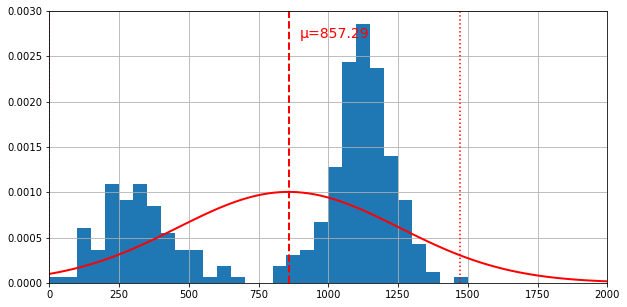

In [169]:
σ = delay.std()
μ = delay.mean()
norm = stats.norm(loc=μ, scale=σ).pdf
plot(delay, pdf=norm, xmin=0, xmax=2000, bins=np.linspace(0, 2000, 41))
print(f"{max((μ-delay.min())/σ,  (delay.max()-μ)/σ):3.1f}σ")

The delay graph of the final simulation has a mean of 857.29 seconds showing average delay in our process is around 14 mins the distribution also show highly platykurtic data indicating kurtosis coefficent below zero.